## Enhanced Model Development and Interrogation using the AITIA Library

**Introduction**

This Jupyter notebook focuses on leveraging the AITIA library to enhance the development and interrogation of machine learning models applied to a dataset comprising military patients who underwent corrective surgery for Chronic Exertional Compartment Syndrome (CECS). The primary predictive target is whether patients return to a fully deployable status within 12 months post-surgery.

The notebook will demonstrate 5 uses for the AITIA library, namely: 

1. A competency analysis to identify and assess the competency of various machine learning models to determine the most suitable candidates for testing and tuning.
2. A concept drift analysis to investigate the resilience of candidate models to potential changes in dataset complexity.
3. Uncertainty explanation to understand why certain patients are more complex than others.
4. Implementation of uncertainty-based abstention as a safeguard mechanism using uncertainty measures to prevent AI usage on patients where model certainty is low.
5. A misclassification analysis to identify patterns and commonalities contributing to remaining errors.

### Set up

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
models = [LogisticRegression(class_weight='balanced',C=0.25,penalty='l2',solver='liblinear'),
          SVC(probability=True, max_iter=100,class_weight='balanced',C=0.45,gamma='scale',kernel='linear'),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', KNeighborsClassifier(metric='manhattan',weights='uniform',n_neighbors=11,algorithm='brute'))]),
          RandomForestClassifier(class_weight='balanced',max_features='sqrt',n_estimators=20,max_depth=3,warm_start=True),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', AdaBoostClassifier())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', GaussianNB())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', LinearDiscriminantAnalysis())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', QuadraticDiscriminantAnalysis())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', MLPClassifier(max_iter=10))]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=20,booster='gblinear'))])]

model_names = ['Logistic Regression',
               'SVM',
               'KNN',
               'Random Forest',
               'Adaboost',
               'Naive Bayes',
               'Linear Discriminant Analysis',
               'Quadratic Discriminant Analysis',
               'Neural Network',
               'XGBoost']

model_dict = dict(zip(model_names, models))

In [3]:
import pandas as pd
import warnings
import mrmr
warnings.filterwarnings("ignore")

In [4]:
# Define the list of feature names
feature_names =  ['age', 'rank', 'height', 'weight', 'bmi', 'bp_s', 'bp_d', 'bp', 'map', 'smoker', 'alcohol', 'faam', 'eilp', 'chronicity', 'ttp', 'ttd', 'ttt', 'wait time', 'time_dg', 'co_morb', 'prior_injuries', 'prior_surgery', 'prior_courses']

# Read the feature data from a CSV file into a Pandas DataFrame
X = pd.read_csv('data//X.csv', header=None)

# Assign the feature names to the columns of the DataFrame
X.columns = feature_names

# Read the target variable (labels) from a CSV file into a Pandas DataFrame
y = pd.read_csv('data//y.csv', header=None)

# Assign a column name ('labels') to the target variable
y.columns = ['labels']

# Use the mrmr_classif function to select features based on minimum redundancy maximum relevance
selected_features = mrmr.mrmr_classif(X, y.iloc[:, 0].values, K=X.shape[1])

# Initialize a list with the first selected feature
valid_features = [selected_features[0]]

# Iterate over the remaining selected features and check for correlation with already selected features
for feat in range(1, X.shape[1]):
    # Check if the absolute correlation between the current feature and the valid features is greater than 0.5
    if any(abs(X[valid_features + [selected_features[feat]]].corr().iloc[:-1, -1].values) > 0.5):
        # If the correlation is greater than 0.5, skip adding the feature to the valid features list
        pass
    else:
        # If the correlation is not greater than 0.5, add the feature to the valid features list
        valid_features.append(selected_features[feat])

# Create a new DataFrame (X_) containing only the selected valid features
X_ = X[valid_features].copy()

100%|██████████| 23/23 [00:04<00:00,  5.64it/s]


### Competency Analysis

In [5]:
from interrogation_analysis import CompetencyAnalysis
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
competency_analyser = CompetencyAnalysis(n_datasets=200, pop_size=30, n_gen=10)
competency_analyser.prepare_analysis(X_.values,y['labels'].values)

In [9]:
def compare_models(grid, x_coords, y_coords):
    titles = ['Top Ranked Model', '2nd Ranked Model', '3rd Ranked Model']

    # Set the size of the figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Define a custom color map with 10 colors
    colors = sns.color_palette("pastel", 10)

    # Loop through the top 3 ranked models
    for rank in range(3):
        # Get indices for the current rank
        indices = np.argsort(grid, axis=2)[:, :, -rank - 1]

        # Flatten the coordinates and sorted indices
        x_flattened = x_coords.flatten()
        y_flattened = y_coords.flatten()
        indices_flattened = indices.flatten()
        c = [colors[i] for i in indices_flattened]

        # Create a scatter plot for the current rank using Seaborn
        sns.scatterplot(x=x_flattened, y=y_flattened, c=c, marker='o', ax=axes[rank])
        axes[rank].scatter(competency_analyser.f1_score, competency_analyser.n1_score, color='red', edgecolors='k', linewidths=1, marker='s', s=50, label='Original Dataset')

        # Remove color legend from the Seaborn plot
        axes[rank].set_title(titles[rank], fontsize=16)  # Set title fontsize
        axes[rank].set_xlabel('F1 Score', fontsize=14)  # Set xlabel fontsize
        axes[rank].set_ylabel('N1 Score', fontsize=14)  # Set ylabel fontsize
        axes[rank].set_ylim(y_coords[0][0], y_coords[-1][-1])
        axes[rank].set_xlim(x_coords[0][0], x_coords[-1][-1])

    # Create a legend for the models and original specification
    legend_handles = []
    legend_labels = []
    for i, model in enumerate(model_names):
        legend_handles.append(plt.scatter([0], [0], marker='o', c=colors[i], label=model))
        legend_labels.append(model)

    # Add the legend to the figure
    legend_handles.append(plt.scatter([0], [0], marker='s', edgecolors='k', linewidths=1, s=50, color='red', label='Original Dataset'))
    legend_labels.append('Original Dataset')
    fig.legend(handles=legend_handles, labels=legend_labels, loc='upper right', bbox_to_anchor=(1.17, 1), fontsize=12)  # Set legend fontsize

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

-- Evaluating Logistic Regression --
-- Evaluating SVM --
-- Evaluating KNN --
-- Evaluating Random Forest --
-- Evaluating Adaboost --
-- Evaluating Naive Bayes --
-- Evaluating Linear Discriminant Analysis --
-- Evaluating Quadratic Discriminant Analysis --
-- Evaluating Neural Network --
-- Evaluating XGBoost --


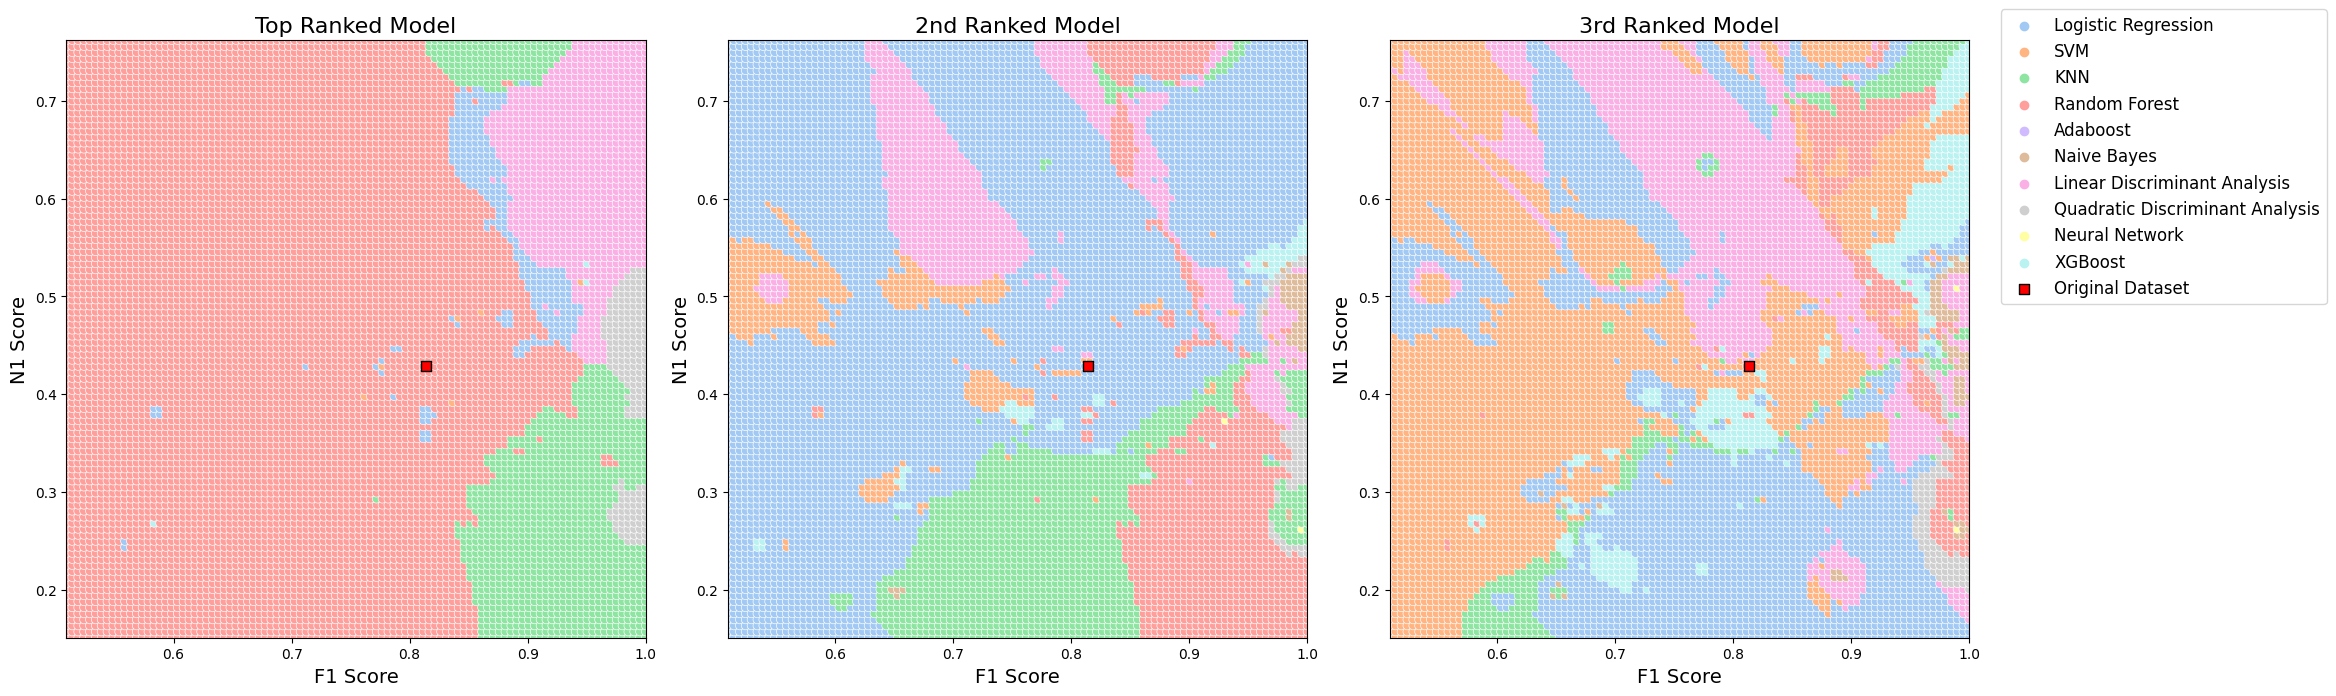

In [12]:
results = {}
for model_name, model in model_dict.items():
    print(f'-- Evaluating {model_name} --')
    results[model_name] = {}
    competency_analyser.evaluate_competency(model=model)
    results[model_name]['scores'] = [{'F1': v['F1'], 'N1': v['N1'], 'score': v['score']} for v in competency_analyser.datasets.values()]
    
    # Extract F1, N1, and scores from the datasets
    f1_scores = [v['F1'] for v in competency_analyser.datasets.values()]
    n1_scores = [v['N1'] for v in competency_analyser.datasets.values()]
    scores = [v['score'] for v in competency_analyser.datasets.values()]

    f1_scores_ = []
    n1_scores_ = []
    scores_ = []
    for f1, n1, score in zip(f1_scores, n1_scores, scores):
        if not (np.isnan(f1) or np.isnan(n1) or np.isnan(score)).any():
            f1_scores_.append(f1)
            n1_scores_.append(n1)
            scores_.append(score)

    # Set up a grid for the heatmap
    f1_range = np.linspace(min(f1_scores), max(f1_scores), 100)
    n1_range = np.linspace(min(n1_scores), max(n1_scores), 100)
    f1_mesh, n1_mesh = np.meshgrid(f1_range, n1_range)

    # Use k-nearest neighbors regression to predict accuracy at each grid point
    knn_regressor = KNeighborsRegressor(n_neighbors=20, weights='distance')
    knn_regressor.fit(np.column_stack((f1_scores_, n1_scores_)), scores_)

    # Predict the score at each grid point
    score_grid = knn_regressor.predict(np.column_stack((f1_mesh.ravel(), n1_mesh.ravel())))

    # Reshape the predicted score to the shape of the meshgrid
    score_grid = score_grid.reshape(f1_mesh.shape)
    results[model_name]['score_grid'] = score_grid

grid = np.zeros((100,100,10))
for i, k in enumerate(results.keys()):
    grid[:,:,i] = results[k]['score_grid']

compare_models(grid, f1_mesh, n1_mesh)

### Determine Performance of best 5 models on the CECS Dataset

In [6]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV

In [7]:
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [10, 20, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1, 2]
}

param_grid_lda = {}  # LinearDiscriminantAnalysis does not have hyperparameters to tune

param_grid_xgb = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [1, 2],
    'n_estimators': [10, 20, 50, 100],
    'booster': ['gbtree', 'gblinear', 'dart']
}

models = [LogisticRegression(class_weight='balanced'),
          SVC(probability=True, max_iter=100,class_weight='balanced'),
          RandomForestClassifier(class_weight='balanced',warm_start=True),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', LinearDiscriminantAnalysis())]),
          Pipeline([('smote', SMOTE(sampling_strategy='auto', random_state=42)), ('clf', XGBClassifier())])]

model_names = ['Logistic Regression',
               'SVM',
               'Random Forest',
               'Linear Discriminant Analysis',
               'XGBoost']

# Perform hyperparameter tuning for each model
tuned_models = []
for model, param_grid in zip(models, [param_grid_logistic, param_grid_svc, param_grid_rf, param_grid_lda, param_grid_xgb]):
    if isinstance(model, Pipeline):
        # If the model is a pipeline, update the 'clf' step with RandomizedSearchCV
        model_name = model.steps[-1][0]
        tuned_model = Pipeline([
            ('smote', model.steps[0][1]),  # Assuming the first step is 'smote'
            ('clf', RandomizedSearchCV(model.steps[-1][1], param_distributions=param_grid, scoring='roc_auc', n_iter=10, random_state=42, cv=4))
        ])
    else:
        # If the model is not a pipeline, wrap it with RandomizedSearchCV
        model_name = model.__class__.__name__
        tuned_model = RandomizedSearchCV(model, param_distributions=param_grid, scoring='roc_auc', n_iter=10, random_state=42, cv=4)

    tuned_models.append(tuned_model)

# Create the model dictionary
model_dict = dict(zip(model_names, tuned_models))

In [6]:
def sensitivity_function(y_true, y_pred):
  conf_matrix = metrics.confusion_matrix(y_true, y_pred)
  TP = conf_matrix[1][1]
  TN = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  FN = conf_matrix[1][0]

  # calculate the sensitivity
  conf_sensitivity = (TP / float(TP + FN))
  return conf_sensitivity

def specificity_function(y_true, y_pred):
  conf_matrix = metrics.confusion_matrix(y_true, y_pred)
  TP = conf_matrix[1][1]
  TN = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  FN = conf_matrix[1][0]

  # calculate the specificity
  conf_specificity = (TN / float(TN + FP))
  return conf_specificity

def orp_fpr_function(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  i = np.arange(len(tpr))
  roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
  roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
  return list(roc_t['fpr'])[0]

def orp_tpr_function(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  i = np.arange(len(tpr))
  roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
  roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
  return list(roc_t['tpr'])[0]

def evaluate(y_test, y_hat, y_prob):
  acc = metrics.accuracy_score(y_test, y_hat)
  sens = sensitivity_function(y_test, y_hat)
  spec = specificity_function(y_test, y_hat)
  auc = metrics.roc_auc_score(y_test, y_prob)
  orp_fpr = orp_fpr_function(y_test, y_prob)
  orp_tpr = orp_tpr_function(y_test, y_prob)
  return [acc, sens, spec, auc, orp_fpr, orp_tpr]

sensitivity = metrics.make_scorer(sensitivity_function, greater_is_better=True)
specificity = metrics.make_scorer(specificity_function, greater_is_better=True)
orp_fpr = metrics.make_scorer(orp_fpr_function, greater_is_better=True, needs_proba=True)
orp_tpr = metrics.make_scorer(orp_tpr_function, greater_is_better=True, needs_proba=True)
scoring = {'Accuracy' : 'accuracy', 'Sensitivity': sensitivity, 'Specificity' : specificity, 'AUC': 'roc_auc', 'ORP FPR' : orp_fpr, 'ORP TPR' : orp_tpr, 'F1': 'f1'}

In [90]:
results = []
for name, model in model_dict.items():
    scores = cross_validate(estimator=model, X=X_.values, y=y['labels'].values, cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42),scoring=scoring,return_train_score=True)
    results.append([name,
                    str(np.round(np.mean(scores['train_Accuracy']),2)) + ' ± ' + str(np.round(np.std(scores['train_Accuracy']),2)), 
                    str(np.round(np.mean(scores['train_Sensitivity']),2)) + ' ± ' + str(np.round(np.std(scores['train_Sensitivity']),2)), 
                    str(np.round(np.mean(scores['train_Specificity']),2)) + ' ± ' + str(np.round(np.std(scores['train_Specificity']),2)), 
                    str(np.round(np.mean(scores['train_AUC']),2)) + ' ± ' + str(np.round(np.std(scores['train_AUC']),2)), 
                    str(np.round(np.mean(scores['train_ORP FPR']),2)) + ' ± ' + str(np.round(np.std(scores['train_ORP FPR']),2)), 
                    str(np.round(np.mean(scores['train_ORP TPR']),2)) + ' ± ' + str(np.round(np.std(scores['train_ORP TPR']),2))])
    results.append([name,
                    str(np.round(np.mean(scores['test_Accuracy']),2)) + ' ± ' + str(np.round(np.std(scores['test_Accuracy']),2)), 
                    str(np.round(np.mean(scores['test_Sensitivity']),2)) + ' ± ' + str(np.round(np.std(scores['test_Sensitivity']),2)), 
                    str(np.round(np.mean(scores['test_Specificity']),2)) + ' ± ' + str(np.round(np.std(scores['test_Specificity']),2)), 
                    str(np.round(np.mean(scores['test_AUC']),2)) + ' ± ' + str(np.round(np.std(scores['test_AUC']),2)), 
                    str(np.round(np.mean(scores['test_ORP FPR']),2)) + ' ± ' + str(np.round(np.std(scores['test_ORP FPR']),2)), 
                    str(np.round(np.mean(scores['test_ORP TPR']),2)) + ' ± ' + str(np.round(np.std(scores['test_ORP TPR']),2))])

In [91]:
results_df = pd.DataFrame(data = np.vstack(results), columns = ['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'AUROC', 'ORP FPR', 'ORP TPR'])
results_df.to_csv('data//classification_result.csv', index=None)

### Concept Drift Analysis

In [7]:
from interrogation_analysis import ConceptDriftAnalysis

In [13]:
noise = np.random.normal(loc=0, scale=0.05, size=X_.values.shape)
X_noisy = X_.values + noise

drift_analyser = ConceptDriftAnalysis(X_noisy, y['labels'].values, f1_target=1, n1_target=1, pop_size=40, n_gen=10)

drift_analyser.X = X_.values
drift_analyser.X_ = np.round(drift_analyser.X_,0)

drift_results = {}
for name, model in model_dict.items():
    drift_results[name] = drift_analyser.evaluate_concept_drift(model,n_splits=5,scoring='roc_auc')

In [80]:
xticks = []
for v in drift_results['Logistic Regression'].values():
    if v['std_f1'] == 0:
        xticks.append(f"F1 = {np.round(v['mean_f1'],2)}\nN1 = {np.round(v['mean_n1'],2)}")
    else:
        xticks.append(f"F1 = {np.round(v['mean_f1'],2)} ± {np.round(v['std_f1'],2)}\nN1 = {np.round(v['mean_n1'],2)} ± {np.round(v['std_n1'],2)}")

([<matplotlib.axis.XTick at 0x1851118fd30>,
 [Text(0, 0, 'F1 = 0.81\nN1 = 0.43'),
  Text(1, 0, 'F1 = 0.88 ± 0.02\nN1 = 0.43 ± 0.04'),
  Text(2, 0, 'F1 = 0.91 ± 0.01\nN1 = 0.43 ± 0.03'),
  Text(3, 0, 'F1 = 0.93 ± 0.01\nN1 = 0.44 ± 0.02'),
  Text(4, 0, 'F1 = 0.94 ± 0.01\nN1 = 0.44 ± 0.01'),
  Text(5, 0, 'F1 = 0.95\nN1 = 0.42')])

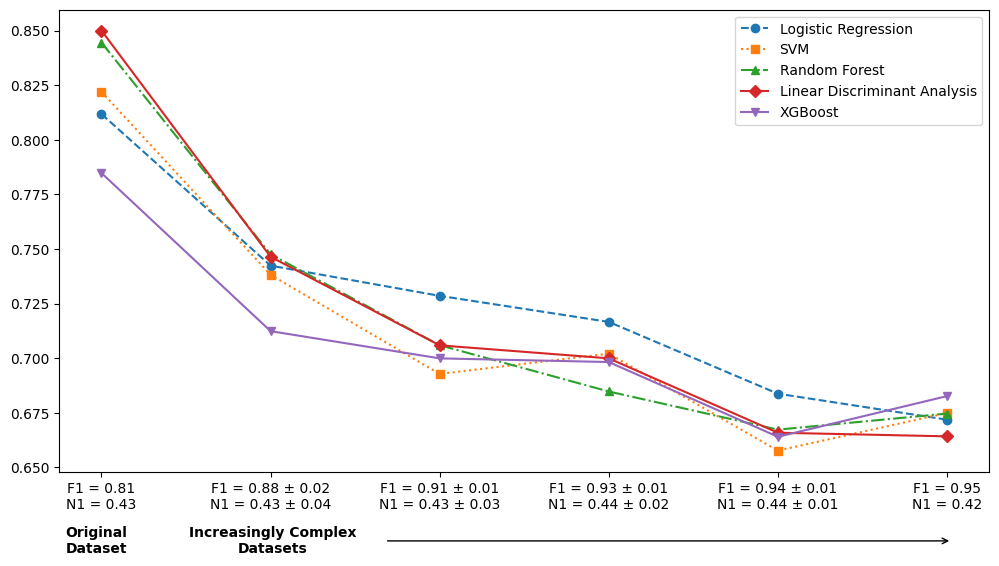

In [129]:
# Set the desired width and height for the figure
fig_width = 12
fig_height = 6

# Create a new figure with the specified size
plt.figure(figsize=(fig_width, fig_height))

# Define line styles and markers for each line
line_styles = ['--', ':', '-.', '-', '-']
markers = ['o', 's', '^', 'D', 'v']

# Your existing code with modified line and marker styles
for i, (k, v) in enumerate(drift_results.items()):
    mean_scores = []
    std_scores = []
    for k_, v_ in v.items():
        mean_scores.append(v_['mean_score'])

    plt.plot(mean_scores, linestyle=line_styles[i], marker=markers[i])

# Add text boxes under the first and last tick labels
plt.text(0.04, -0.15, 'Original\nDataset', transform=plt.gca().transAxes, ha='center', va='center', fontweight='bold')
plt.text(0.23, -0.15, 'Increasingly Complex\nDatasets', transform=plt.gca().transAxes, ha='center', va='center', fontweight='bold')

plt.annotate('', xy=(0.96, -0.15), xycoords='axes fraction', xytext=(0.35, -0.15),
arrowprops=dict(arrowstyle="->", color='k'))

plt.legend(drift_results.keys())
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=xticks)

### Uncertainty-based Abstention

In [6]:
from interrogation_analysis import derive_abstention_threshold
from AITIA.uncertainty_system import UncertaintyEstimator

In [7]:
model = LogisticRegression(class_weight='balanced',C=0.25,penalty='l2',solver='liblinear')

In [47]:
uncertainty_estimator = UncertaintyEstimator(model, categorical_idx=[3,7,9,10,14,15])
uncertainty_estimator.generate_knowledge_base(n_datasets=100, X=X_.values, y=y['labels'].values)

Generating synthetic datasets:   0%|          | 0/100 [00:00<?, ?it/s]

Gen: 1, Best: 0.033, Avg: 0.409, Worst: 1.414
Gen: 2, Best: 0.033, Avg: 0.086, Worst: 0.219
Gen: 3, Best: 0.020, Avg: 0.066, Worst: 0.120
Gen: 4, Best: 0.020, Avg: 0.062, Worst: 0.110
Gen: 5, Best: 0.020, Avg: 0.053, Worst: 0.110
Gen: 6, Best: 0.020, Avg: 0.044, Worst: 0.110
Gen: 7, Best: 0.020, Avg: 0.037, Worst: 0.110
Gen: 8, Best: 0.020, Avg: 0.029, Worst: 0.093


Generating synthetic datasets:   1%|          | 1/100 [00:38<1:03:30, 38.49s/it]

Gen: 1, Best: 0.261, Avg: 0.609, Worst: 1.414
Gen: 2, Best: 0.231, Avg: 0.310, Worst: 0.401
Gen: 3, Best: 0.231, Avg: 0.299, Worst: 0.463
Gen: 4, Best: 0.231, Avg: 0.283, Worst: 0.438
Gen: 5, Best: 0.208, Avg: 0.278, Worst: 0.438
Gen: 6, Best: 0.208, Avg: 0.263, Worst: 0.438
Gen: 7, Best: 0.193, Avg: 0.243, Worst: 0.275
Gen: 8, Best: 0.193, Avg: 0.235, Worst: 0.261
Gen: 9, Best: 0.193, Avg: 0.223, Worst: 0.254


Generating synthetic datasets:   2%|▏         | 2/100 [01:25<1:10:54, 43.41s/it]

Gen: 1, Best: 0.182, Avg: 0.439, Worst: 1.414
Gen: 2, Best: 0.182, Avg: 0.245, Worst: 0.300
Gen: 3, Best: 0.133, Avg: 0.234, Worst: 0.284
Gen: 4, Best: 0.133, Avg: 0.228, Worst: 0.284
Gen: 5, Best: 0.133, Avg: 0.228, Worst: 0.284
Gen: 6, Best: 0.132, Avg: 0.218, Worst: 0.284
Gen: 7, Best: 0.132, Avg: 0.221, Worst: 0.284
Gen: 8, Best: 0.102, Avg: 0.222, Worst: 0.284
Gen: 9, Best: 0.102, Avg: 0.179, Worst: 0.284


Generating synthetic datasets:   3%|▎         | 3/100 [02:13<1:13:38, 45.56s/it]

Gen: 1, Best: 0.164, Avg: 0.498, Worst: 1.414
Gen: 2, Best: 0.164, Avg: 0.277, Worst: 0.366
Gen: 3, Best: 0.090, Avg: 0.244, Worst: 0.366
Gen: 4, Best: 0.090, Avg: 0.224, Worst: 0.308
Gen: 5, Best: 0.090, Avg: 0.216, Worst: 0.335
Gen: 6, Best: 0.050, Avg: 0.227, Worst: 0.300
Gen: 7, Best: 0.050, Avg: 0.201, Worst: 0.300
Gen: 8, Best: 0.050, Avg: 0.169, Worst: 0.300
Gen: 9, Best: 0.050, Avg: 0.139, Worst: 0.273


Generating synthetic datasets:   4%|▍         | 4/100 [31:11<19:01:43, 713.58s/it]

Gen: 1, Best: 0.135, Avg: 0.449, Worst: 1.414
Gen: 2, Best: 0.105, Avg: 0.264, Worst: 0.372
Gen: 3, Best: 0.105, Avg: 0.226, Worst: 0.355
Gen: 4, Best: 0.061, Avg: 0.180, Worst: 0.258


In [ ]:
X = X_.values
y = y['labels'].values

In [41]:
# Create StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_above = {}
results_below = {}

# Iterate through threshold values from 99 to 0
for threshold_ in range(500, -1, -10):
    threshold = threshold_ / 1000.0
    results_below[threshold] = []
    results_above[threshold] = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit uncertainty estimator on training data
    print('fitting')
    uncertainty_estimator.fit(X_train, y_train)

    # Make predictions on the validation set
    print('predicting')
    y_pred, y_prob, uncertainty = uncertainty_estimator.predict(X_val, return_predictions=True)

    for threshold_ in range(500, -1, -10):
        threshold = threshold_ / 1000.0

        # Check if all classes are present in the subset below the threshold
        if all([c in y_val[uncertainty < threshold] for c in np.unique(y_val)]):

            # Calculate the score based on the specified evaluation metric
            score = metrics.roc_auc_score(y_val[uncertainty < threshold], y_prob[uncertainty < threshold, 1])
            results_below[threshold].append(score)
        
        # Check if all classes are present in the subset below the threshold
        if all([c in y_val[uncertainty > threshold] for c in np.unique(y_val)]):

            # Calculate the score based on the specified evaluation metric
            score = metrics.roc_auc_score(y_val[uncertainty > threshold], y_prob[uncertainty > threshold, 1])
            results_above[threshold].append(score)

fitting
predicting
fitting
predicting
fitting
predicting
fitting
predicting
fitting
predicting


In [42]:
mean_score = []
std_score = []
mean_score_ = []
std_score_ = []
for v_,v in zip(results_below.values(), results_above.values()):
    mean_score.append(np.mean(v_))
    std_score.append(np.std(v_))

    mean_score_.append(np.mean(v))
    std_score_.append(np.std(v))

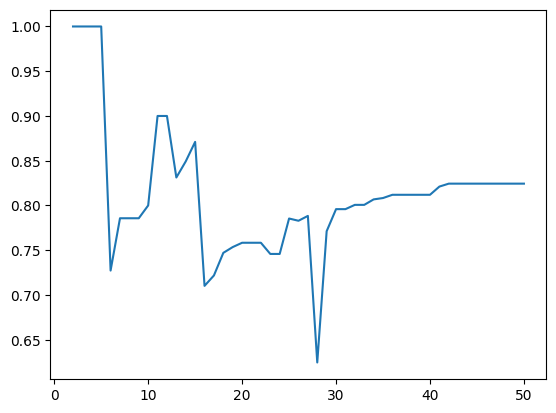

In [44]:
plt.plot(mean_score_)

In [ ]:
abstention_threshold = derive_abstention_threshold(X_.values, y['labels'].values, uncertainty_estimator=uncertainty_estimator)

In [ ]:
# Create StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
y_true_, y_pred_, y_prob_, uncertainty_ = [], [], [], []

# Iterate through threshold values from 99 to 0
for threshold_ in range(500, -1, -10):
    threshold = threshold_ / 1000.0
    results[threshold] = []

for train_index, val_index in skf.split(X_synth, y_synth):
    X_train, X_val = X_synth[train_index], X_synth[val_index]
    y_train, y_val = y_synth[train_index], y_synth[val_index]

    # Fit uncertainty estimator on training data
    print('fitting')
    uncertainty_estimator.fit(X_train, y_train)

    # Make predictions on the validation set
    print('predicting')
    y_pred, y_prob, uncertainty = uncertainty_estimator.predict(X_val, return_predictions=True)
    
    y_true_.append(y_val)
    y_pred_.append(y_pred)
    y_prob_.append(y_prob)
    uncertainty_.append(uncertainty)

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

def calculate_metrics(y_true, y_prob):
    # Calculate AUROC
    auroc = roc_auc_score(y_true, y_prob)

    # Calculate AUPRC
    auprc = average_precision_score(y_true, y_prob)

    # Calculate Odds Ratio
    odds_ratio = np.sum(y_prob[y_true == 1]) / np.sum(y_prob[y_true == 0])

    return auroc, auprc, odds_ratio

auroc = []
auprc = []
odds_ratio = []
for i in range(5):

    a, b, c = calculate_metrics(y_true_[i] != y_pred_[i], uncertainty_[i])
    auroc.append(a)
    auprc.append(b- np.mean(y_true_[i] != y_pred_[i]))
    
    a, b, c = calculate_metrics(y_true_[i] == y_pred_[i], uncertainty_[i])
    odds_ratio.append(c)

print(np.mean(auroc), np.std(auroc))
print(np.mean(auprc), np.std(auprc))
print(np.mean(odds_ratio), np.std(odds_ratio))